#This notebook takes you through three different methods of calculating RVs with errors. Read through the notebook with your group members and discuss how each of the methods works. Note how the different methods change the determinations of the measured errors on the RVs.

#Ultimately, we will use the "bootstrap" method to calculate the error on our radial velocities. A bootstrap is similar to a Monte Carlo, which we discussed in class, except we are resamplying from our actual data instead of creating a synthetic set of observations.

#At the end, you should be able to explain how the RVs were calculated using broadening functions and include an explanation in the "data reduction and analysis" section of your group paper.  As part of this notebook, you will write two paragraphs describing our analysis method that you can include in your group paper.

In [32]:
#package imports
import saphires
import matplotlib
import pandas as pd
import numpy as np
import os
from scipy.optimize import curve_fit
%matplotlib inline
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
import pickle as pkl
from scipy.ndimage import gaussian_filter

In [33]:
#Constants
R_coude = 60000.0 #spectral resolution of the Coude.
c = (2.9979245*10**5) #speed of light in km/s

#To measure RVs and vsinis, we will not be analyzing the spectra themselves, but a data product that we have computed for you called a broadening function. The code below shows how to plot and combine the broadening functions we will be analyzing. With your group, read the explanation of Spectral-Line Broadening Functions here:
https://saphires.readthedocs.io/en/latest/intro.html#spectral-line-broadening-functions-bf

#Then, look through the code below that plots some spectral orders and their broadening functions





In [34]:
#The .p files are broadening functions of our spectra, one for each observation.
# For this example we will just look at just one of the observation of my star, V846Her.
!ls /Users/edinpeskovic/Documents/'research summer 2024'/'Spectroscopy Lab'/coude_SSG_data/V846Her/V846Her*.p

/Users/edinpeskovic/Documents/research summer 2024/Spectroscopy Lab/coude_SSG_data/V846Her/V846Her_2020-05-10_0_5100_4.5.p
/Users/edinpeskovic/Documents/research summer 2024/Spectroscopy Lab/coude_SSG_data/V846Her/V846Her_2020-08-06_0_5100_4.5.p
/Users/edinpeskovic/Documents/research summer 2024/Spectroscopy Lab/coude_SSG_data/V846Her/V846Her_2020-09-03_0_5100_4.5.p
/Users/edinpeskovic/Documents/research summer 2024/Spectroscopy Lab/coude_SSG_data/V846Her/V846Her_2021-03-31_0_5100_4.5.p
/Users/edinpeskovic/Documents/research summer 2024/Spectroscopy Lab/coude_SSG_data/V846Her/V846Her_2021-05-04_0_5100_4.5.p


In [35]:
#read the pickle file in like this
tar,tar_spec = pkl.load(open('/Users/edinpeskovic/Documents/research summer 2024/Spectroscopy Lab/coude_SSG_data/V846Her/V846Her_2020-05-10_0_5100_4.5.p','rb'))

In [36]:
#Here is the list of dictionary keys
for i in range(tar.size):
    print(i,tar[i])
#These regions have been selected to use in the broadening function calculations
#to avoid telluric contamination and emission lines.

0 V846Her_2020-05-10_0.pkl[12][4322-4381]
1 V846Her_2020-05-10_0.pkl[13][4381-4438]
2 V846Her_2020-05-10_0.pkl[14][4438-4493]
3 V846Her_2020-05-10_0.pkl[15][4499-4557]
4 V846Her_2020-05-10_0.pkl[16][4557-4618]
5 V846Her_2020-05-10_0.pkl[17][4618-4659]
6 V846Her_2020-05-10_0.pkl[18][4677-4743]
7 V846Her_2020-05-10_0.pkl[19][4746-4803]
8 V846Her_2020-05-10_0.pkl[20][4816-4876]
9 V846Her_2020-05-10_0.pkl[21][4879-4943]
10 V846Her_2020-05-10_0.pkl[22][4951-5019]
11 V846Her_2020-05-10_0.pkl[23][5026-5084]
12 V846Her_2020-05-10_0.pkl[24][5100-5161]
13 V846Her_2020-05-10_0.pkl[25][5176-5245]
14 V846Her_2020-05-10_0.pkl[26][5256-5326]
15 V846Her_2020-05-10_0.pkl[27][5334-5412]
16 V846Her_2020-05-10_0.pkl[28][5416-5499]
17 V846Her_2020-05-10_0.pkl[29][5502-5574]
18 V846Her_2020-05-10_0.pkl[30][5596-5672]
19 V846Her_2020-05-10_0.pkl[31][5689-5767]
20 V846Her_2020-05-10_0.pkl[32][5786-5868]
21 V846Her_2020-05-10_0.pkl[33][5882-5950]
22 V846Her_2020-05-10_0.pkl[34][5994-6069]
23 V846Her_2020-05-10

In [37]:
#how many spectral orders did we consider?
tar.size

34

In [38]:
#For each key (i.e., each order), here are the available data:
tar_spec[tar[0]].keys()

dict_keys(['nflux', 'nwave', 'ndw', 'wav_cent', 'w_region', 'rv_shift', 'order_flag', 'temp_name', 'vflux', 'vwave', 'vflux_temp', 'vel_spacing', 'w_region_temp', 'bf', 'vel', 'bf_sig'])

### Per-order keys
#### 'nflux' - continuum normalized flux (inverted^1) of the target in the native pixel spacing
#### 'nwave' - wavelength array associated with 'nflux'
#### 'ndw' - native wavelength spacing between pixels
#### 'wav_cent' - central wavelength of the order
#### 'w_region' - string describing the region of this order that was used to compute the BF
#### 'rv_shift' - A stored rv shift, if any, usually 0
#### 'order_flag' - boolean, will be False if something in the BF computation failed for this order
#### 'temp_name' - name of the template used to compute the BF
#### 'vflux' - continuum normalized flux (inverted^1) of the target in equal-velocity wavelength spacing^2 spacing
#### 'vwave' - wavelength array associated with vflux
#### 'vflux_temp' - continuum normalized flux (inverted^1) of the template in equal-velocity wavelength spacing^2 spacing
#### 'vel_spacing' - velocity spacing of the resampled array
#### 'w_region_temp' - string describing the region of the template that was used to compute the BF
#### 'bf' - the broadening function for this order, as a function of radial velocity
#### 'vel' - the velocity array associated with 'bf'
#### 'bf_sig' - a measure of the weight to assign this order's BF (I don't typically use this)

##### ^1 as a convention, all the computations are done on inverted flux arrays, i.e., the continuum is zero and absorption lines go up toward 1.
##### ^2 To compute the BF (or CCF) you have to resample the spectrum such that the pixel spacing corresponds to a constant velocity step (logarithmic wavelength spacing).

### Lets plot the spectrum of the order near 6000 A (index 22)

Text(0, 0.5, '1-Normalized Flux')

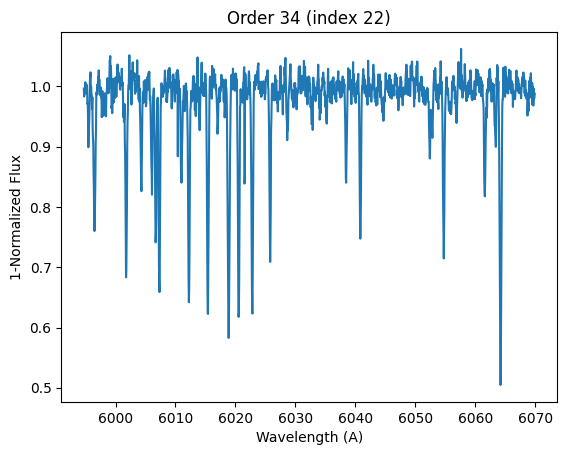

In [39]:
fig,ax = plt.subplots(1)

ax.plot(tar_spec[tar[22]]['nwave'],1-tar_spec[tar[22]]['nflux'])
#see, it's inverted.
ax.set_title('Order 34 (index 22)')
ax.set_xlabel('Wavelength (A)')
ax.set_ylabel('1-Normalized Flux')


### Now lets plot the normalized, resampled spectrum of our target, and compare it to a template spectrum. We want to compute the wavelength shift between the template and our observation

Text(0, 0.5, '1-Normalized Flux')

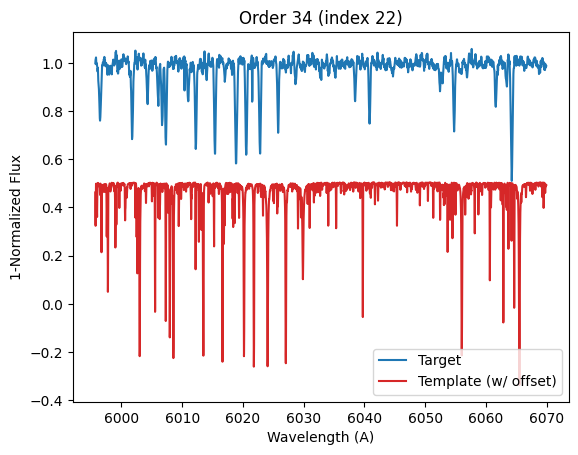

In [9]:
fig, ax = plt.subplots(1)


#Let's overplot the velocity version:
ax.plot(tar_spec[tar[22]]['vwave'],1-tar_spec[tar[22]]['vflux'],label='Target')
#looks the same good

#Let's overplot the template too and offset it below
ax.plot(tar_spec[tar[22]]['vwave'],1-tar_spec[tar[22]]['vflux_temp']-0.5,
        label='Template (w/ offset)',color='C3')

ax.legend()

ax.set_title('Order 34 (index 22)')
ax.set_xlabel('Wavelength (A)')
ax.set_ylabel('1-Normalized Flux')

### The broadening function is computed as a function of radial velocity. It essentially tells us what RV shift would shift our template spectrum to best match our observed spectrum. Lets plot the broadening function computed for the spectral order we plotted above

Text(0, 0.5, 'Broadening Function')

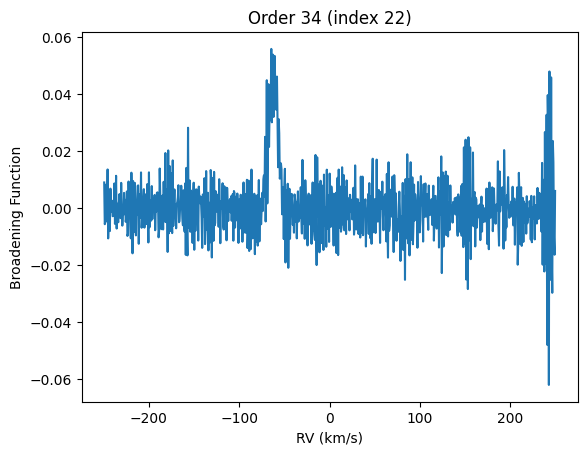

In [10]:
fig,ax = plt.subplots(1)

ax.plot(tar_spec[tar[22]]['vel'],tar_spec[tar[22]]['bf'])

ax.set_title('Order 34 (index 22)')
ax.set_xlabel('RV (km/s)')
ax.set_ylabel('Broadening Function')

The broadening function above has a much finer velocity resolution than the resolution of our data, which is set by the resolution of the instrument we are using (the Coude spectrograph). Therefore, we must smooth our broadening function to match the spectral resolution of our observations. Lets smooth our BF, and then plot the smoothed version.

In [11]:
tar_spec = saphires.bf.analysis(tar,tar_spec,R = R_coude)
tar_spec[tar[22]].keys()

dict_keys(['nflux', 'nwave', 'ndw', 'wav_cent', 'w_region', 'rv_shift', 'order_flag', 'temp_name', 'vflux', 'vwave', 'vflux_temp', 'vel_spacing', 'w_region_temp', 'bf', 'vel', 'bf_sig', 'bf_smooth', 'bf_fits', 'bf_rv'])

Text(0, 0.5, 'Broadening Function')

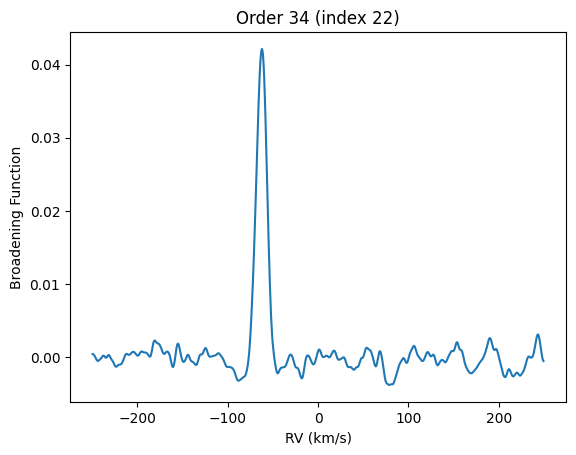

In [12]:
fig,ax = plt.subplots(1)

ax.plot(tar_spec[tar[22]]['vel'],tar_spec[tar[22]]['bf_smooth'])

ax.set_title('Order 34 (index 22)')
ax.set_xlabel('RV (km/s)')
ax.set_ylabel('Broadening Function')

The broadening function we plotted above is for one spectral order. Remember that we have broadening functions for 34 different spectral orders for this observation. Lets plot the broadening functions for all our orders.

34


Text(0, 0.5, 'Broadening Function')

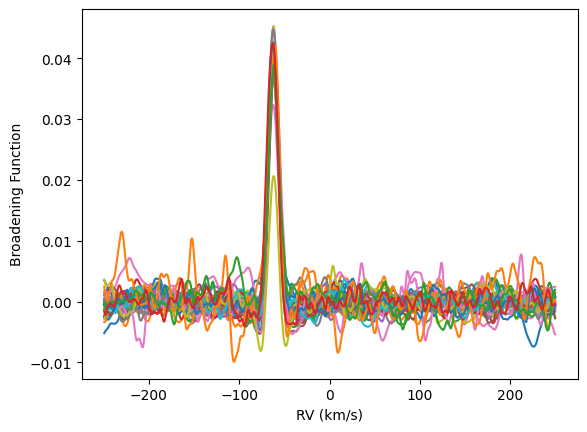

In [13]:
#how many spectral orders did we consider?
print(tar.size)

fig,ax = plt.subplots(1)

for i in range(tar.size):
    ax.plot(tar_spec[tar[i]]['vel'],tar_spec[tar[i]]['bf_smooth'])

ax.set_xlabel('RV (km/s)')
ax.set_ylabel('Broadening Function')

### For each of our 34 orders, we can compute a broadening function. The peak of each of these broadening functions gives the RV measurement for that particular order. If we measure the RV in each of our orders independently, we can use the mean and standard deviation to compute a measurement of the RV and the associated error.

### The code below plots the RV measured from the broadening function for each order as a function of the central wavelength of the order. Most orders measure a similar RV, although there may be an outlier or two that were not well measured.

Text(0, 0.5, 'RV (km/s)')

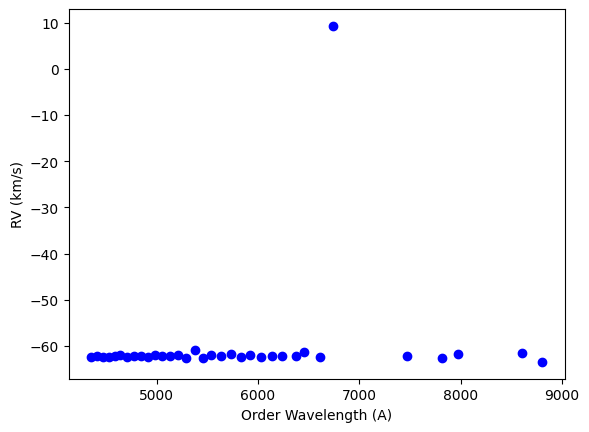

In [14]:
fig,ax = plt.subplots(1)

for i in range(tar.size):
    ax.plot(tar_spec[tar[i]]['wav_cent'],tar_spec[tar[i]]['bf_rv'],'bo')

ax.set_xlabel('Order Wavelength (A)')
ax.set_ylabel('RV (km/s)')

Text(0, 0.5, 'RV (km/s)')

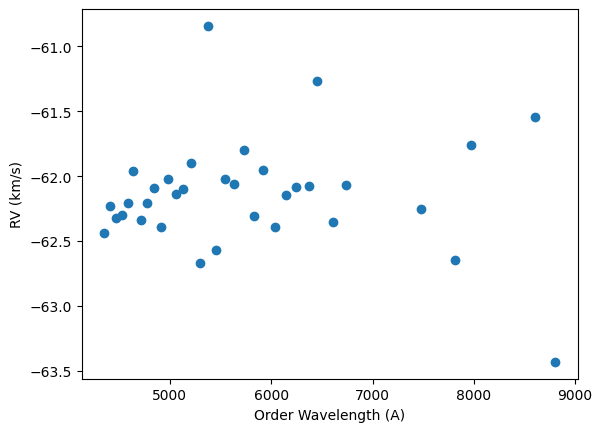

In [15]:
#lets zoom in to see the average RV more clearly
tar_spec = saphires.bf.analysis(tar,tar_spec,R = R_coude,p_rv=-62)

fig,ax = plt.subplots(1)

for i in range(tar.size):
    ax.plot(tar_spec[tar[i]]['wav_cent'],tar_spec[tar[i]]['bf_rv'],'oC0')

ax.set_xlabel('Order Wavelength (A)')
ax.set_ylabel('RV (km/s)')

### RV Measurement Method 1: Take the mean and standard deviation of the measurements of each spectral order
### We can use the mean and standard deviation of our measurements to compute our best measurement of the RV (the mean of our sample) and the associated error on the mean (sigma/sqrt(N))

In [16]:
rv_o = np.zeros(tar.size)
for i in range(tar.size):
    rv_o[i] = tar_spec[tar[i]]['bf_rv']
print("RV:",np.round(np.median(rv_o),2),"+\-",np.round(np.std(rv_o)/np.sqrt(rv_o.size),2))
#note for this error, we are treating each spectral order as its own measurement
# and taking the error to be sigma/sqrt(N)

#This error is slightly higher than we can achieve with better processing

RV: -62.14 +\- 0.07


<>:4: SyntaxWarning: invalid escape sequence '\-'
<>:4: SyntaxWarning: invalid escape sequence '\-'
/var/folders/kf/v0g3d6kx2cjf48cdq0s3lxyc0000gn/T/ipykernel_1349/1573452313.py:4: SyntaxWarning: invalid escape sequence '\-'
  print("RV:",np.round(np.median(rv_o),2),"+\-",np.round(np.std(rv_o)/np.sqrt(rv_o.size),2))


##WRITING ASSIGNMENT 1: Now that you have read through the code and seen how broadening functions can be used to compute RVs, lets write a description of this analysis technique. As a group, write a paragraph explaining what a broadening function is and how it can be used to compute a radial velocity. Add this paragraph to the data reduction+analysis section of your paper

# RV Measurement method 2: Create an averaged broadening function weighted by the noise in each order. Use the error from scipy.curve_fit.
### The code above is a basic way to compute RVs with an error from our spectra. Read through the rest of the code with your group. This shows how to combine the BFs from all the orders and weight them by the noise in the observation. To measure the noise background in an order, we use the high velocity region of the broadening function which should be very close to zero as long as our star does not have a very large RV shift. In this case, we will use regions above +150 km/s and regions below -150 km/s as an estimate of noise in our broadening function, and weight observations with less noise more heavily in our combined BF.

Text(0, 0.5, 'Broadening Function')

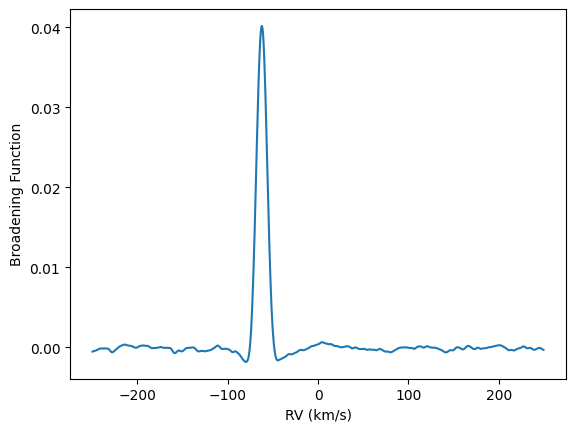

In [17]:
vel,bf,bf_sterr,bf_wstd = saphires.bf.weight_combine(tar,tar_spec,vel_gt_lt=(+150,-150))

fig,ax = plt.subplots(1)

ax.plot(vel,bf)

ax.set_xlabel('RV (km/s)')
ax.set_ylabel('Broadening Function')

Text(0, 0.5, 'Broadening Function')

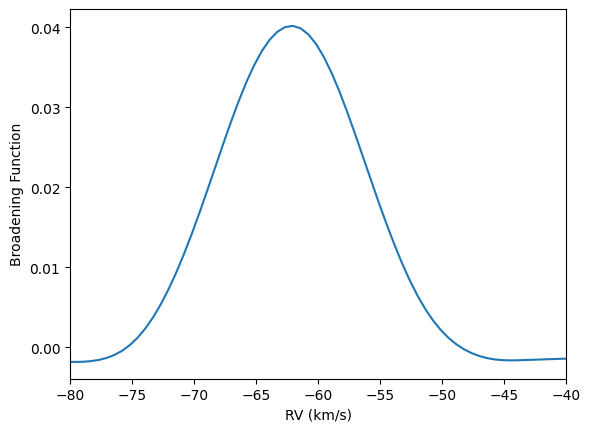

In [18]:
#zoom in more, we see the BF has a peak around an RV of -62 km/s,
#an amplitude of 0.04, a FWHM of about 15 km/s, and a background close to 0
fig,ax = plt.subplots(1)

ax.plot(vel,bf)
ax.set_xlim(-80,-40)

ax.set_xlabel('RV (km/s)')
ax.set_ylabel('Broadening Function')

In [19]:
#this uses a built in saphires utility that uses scipy.curve_fit to fit a gaussian to
# your broadening function, just as we did when we fit a gaussian to line profiles
#(just more automated).
fit,covar = curve_fit(saphires.utils.gaussian_off,vel,bf,p0=(0.05,-62,10,0))

#helps to enter a guess (p0) or the fit can go to weird places.
#The guess parameters are ordered as Amplitude, RV, sigma, offset and you estimate them from the plot above

Text(0.5, 1.0, 'Weighted Broadening Function')

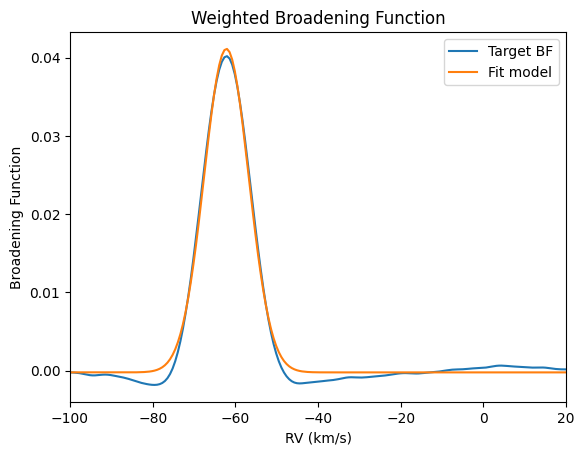

In [20]:
fig,ax = plt.subplots(1)

ax.plot(vel,bf,label='Target BF')
ax.plot(vel,saphires.utils.gaussian_off(vel,*fit),label='Fit model')
ax.set_xlim(-100,20)

ax.legend()

ax.set_xlabel('RV (km/s)')
ax.set_ylabel('Broadening Function')
ax.set_title('Weighted Broadening Function')

Lets print the fit parameters curve_fit gives us. The mean of the fit is the best-fit RV, and we can look at the diagonals of the covariance matrix to get the associated uncertainty on each fit parameter that curve_fit automatically computes.

In [21]:
rv_lsfit = fit[1]
rverr_lsfit = np.sqrt(covar[1,1])

print("RV:",np.round(rv_lsfit,2),"+\-",np.round(rverr_lsfit,2))

RV: -62.17 +\- 0.02


<>:4: SyntaxWarning: invalid escape sequence '\-'
<>:4: SyntaxWarning: invalid escape sequence '\-'
/var/folders/kf/v0g3d6kx2cjf48cdq0s3lxyc0000gn/T/ipykernel_1349/2534470060.py:4: SyntaxWarning: invalid escape sequence '\-'
  print("RV:",np.round(rv_lsfit,2),"+\-",np.round(rverr_lsfit,2))


This error determination is almost certainly too low because curve_fit does not take into account the errors on our observations. To compute a more realistic error, lets use a bootstrap method to resample our data.

### RV Measurement Method 3: Create an averaged broadening function weighted by the noise in each order. Measure errors using a bootstrap method.
### A bootstrap is like a Monte Carlo, which we discussed in lecture, but instead of generating a synthetic data set to analyze, we resample our actual observations. We can do this because we have many different spectral orders to choose from, and can resample a subset of them over and over, comparing the measured RV between each sample.

In [22]:
n_boot = 500 #number of bootstrap iterations to perform
rv_boot_dist = np.zeros(n_boot) #a blank array of RV values to fill
bf_boot_dist = np.zeros([n_boot,vel.size]) #an array to save the BFs we create
print(vel.size)
for i in range(n_boot):
    rindwr = np.random.randint(0,tar.size,tar.size) #randomly sample the contributing orders with replacement.
    tar_i = tar[rindwr] #pick out the selected orders
    vel_i,bf_i,bf_ste_i,bf_wstd_i = saphires.bf.weight_combine(tar_i,tar_spec,vel_gt_lt=(+150,-150)) #create a version of the combined BF
    fit_i = (curve_fit(saphires.utils.gaussian_off,vel_i,bf_i,p0=(0.05,-62,10,0)))[0] #fit it
    rv_boot_dist[i] = fit_i[1] #save the RV
    bf_boot_dist[i,:] = bf_i

797


If we plot the results of our bootstrap, then we see that the measured RVs are distributed in an approximately normal curve. We can measure the standard deviation of the curve to get an error measurement.

RV: -62.17 + 0.06 - 0.07


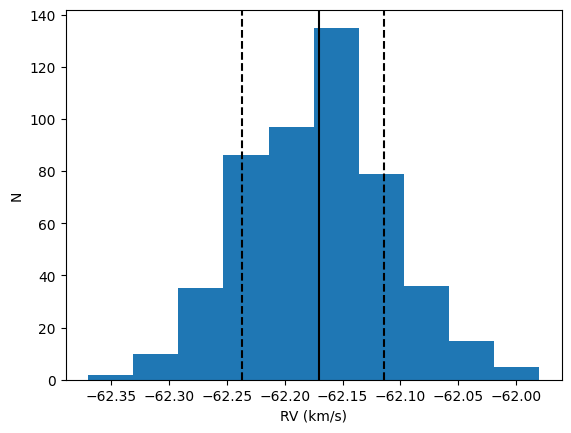

In [23]:
rv_boot_16,rv_boot_med,rv_boot_84 = np.percentile(rv_boot_dist,[16,50,84])
rv_booterr_lo = rv_boot_med - rv_boot_16
rv_booterr_hi = rv_boot_84 - rv_boot_med

fig,ax = plt.subplots(1)

ax.hist(rv_boot_dist)
ax.axvline(rv_boot_med,color='k',ls='-')
ax.axvline(rv_boot_16,color='k',ls='--')
ax.axvline(rv_boot_84,color='k',ls='--')

ax.set_xlabel('RV (km/s)')
ax.set_ylabel('N')

print('RV:',np.round(rv_boot_med,2),'+',np.round(rv_booterr_hi,2),'-',np.round(rv_booterr_lo,2))

The final step is to apply a barycentric correction that accounts for the motion of the earth about the barycenter of the solar system. This correction is given in the header file for the observations ('starname_coude_head.dat') and you should have supplied at the beginning of the notebook when you read in your file.

Note that the error on this correction is extremely small compared to our measurement precision, so we will not worry about propogating this uncertainty.

In [24]:
V846Her = pd.read_csv('/Users/edinpeskovic/Documents/research summer 2024/Spectroscopy Lab/coude_SSG_data/V846Her/V846Her_coude_head.dat')
V846Her.head()

,#Name,Tele,DATE-OBS,EXPTIME,BJD,BVCORR
V846Her_2020-05-10_0.pkl,mcdonald,2020-05-10T08:34:29.059,0,576.218,2.458980e+06,3.623
V846Her_2020-08-06_0.pkl,mcdonald,2020-08-06T04:38:51.056,1,635.211,2.459068e+06,-20.178
V846Her_2020-09-03_0.pkl,mcdonald,2020-09-03T03:29:05.177,2,189.695,2.459096e+06,-20.547
V846Her_2021-03-31_0.pkl,mcdonald,2021-03-31T09:13:27.100,3,1217.479,2.459305e+06,16.139
V846Her_2021-05-04_0.pkl,mcdonald,2021-05-04T07:05:10.178,4,224.676,2.459339e+06,5.994


In [25]:
BVCORR = V846Her["BVCORR"].to_numpy()
print('RV (uncorrected):',np.round(rv_boot_med,2),'+',np.round(rv_booterr_hi,2),'-',np.round(rv_booterr_lo,2))

### Last step, convert to barcentric RV. This has already been computed and is in the starname_coude_head.dat file.
brv_boot = (rv_boot_med) + BVCORR + ((rv_boot_med) * BVCORR / c)
print('RV (barycenter corrected):',np.round(brv_boot,2),'+',np.round(rv_booterr_hi,2),'-',np.round(rv_booterr_lo,2))### Last step, convert to barcentric RV. This has already been computed and is in the starname_coude_head.dat file.


RV (uncorrected): -62.17 + 0.06 - 0.07
RV (barycenter corrected): [-58.55 -82.34 -82.71 -46.03 -56.18] + 0.06 - 0.07


#WRITING ASSIGNMENT 2: Ultimately, we will use the weighted average broadening function to measure our RVs with uncertainties determined using this bootstrap method. As a group, write a paragraph explaining this method in your own words. Add this paragraph to your data reduction and analysis section of your group paper.

#Now each member of your group should measure the RVs (and vsinis) of your star using this method. The notebook vsini_rv_measurement.ipynb walks you through these measurements and some analysis.